In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm, skew

In [3]:
train = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv')

In [4]:
pd.set_option('display.max_columns', None)
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [5]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]

In [6]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2000

In [7]:
train.shape

(200000, 202)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [9]:
train.isna().sum()

# no missing values

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

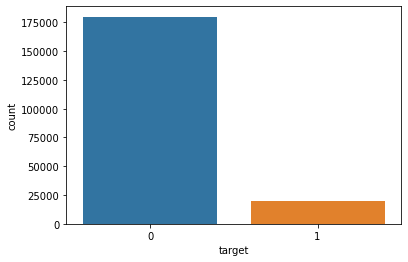

In [10]:
y = train['target']
sns.countplot(y)

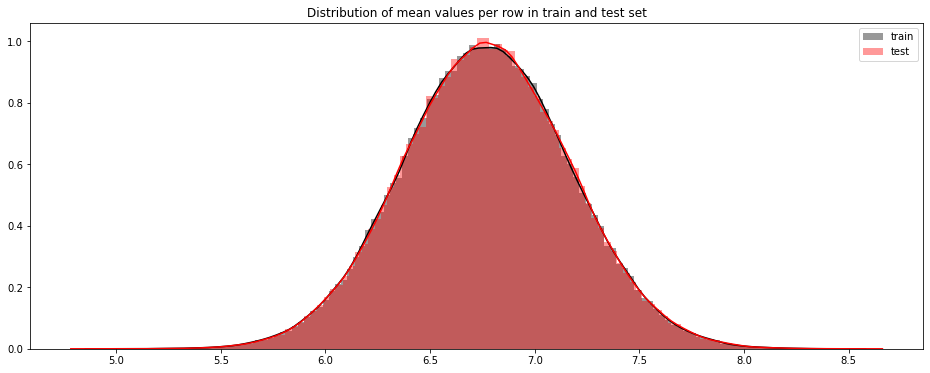

In [11]:
plt.figure(figsize = (16, 6))
plt.title('Distribution of mean values per row in train and test set')
sns.distplot(train[features].mean(axis = 1), color = 'black', kde = True, bins = 120, label = 'train')
sns.distplot(test[features].mean(axis = 1), color = 'red', kde = True, bins = 120, label ='test')
plt.legend()
plt.show()

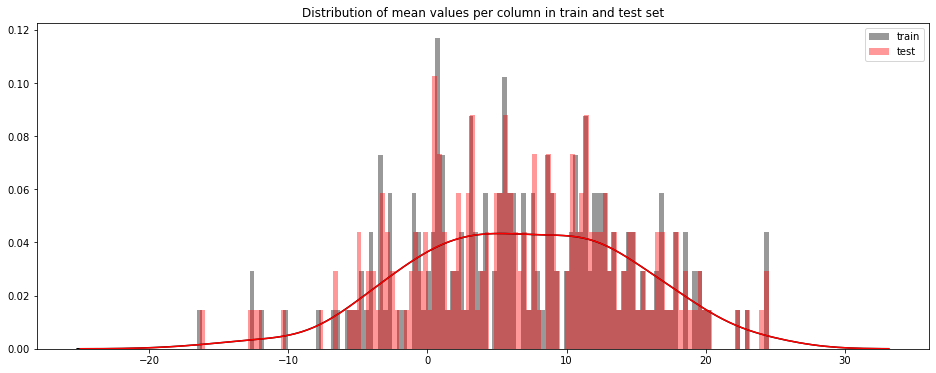

In [12]:
plt.figure(figsize= (16, 6))
plt.title('Distribution of mean values per column in train and test set')
sns.distplot(train[features].mean(axis = 0), color = 'black', kde = True, bins = 120, label='train')
sns.distplot(test[features].mean(axis = 0), color = 'red', kde = True, bins = 120, label = 'test')
plt.legend()
plt.show()

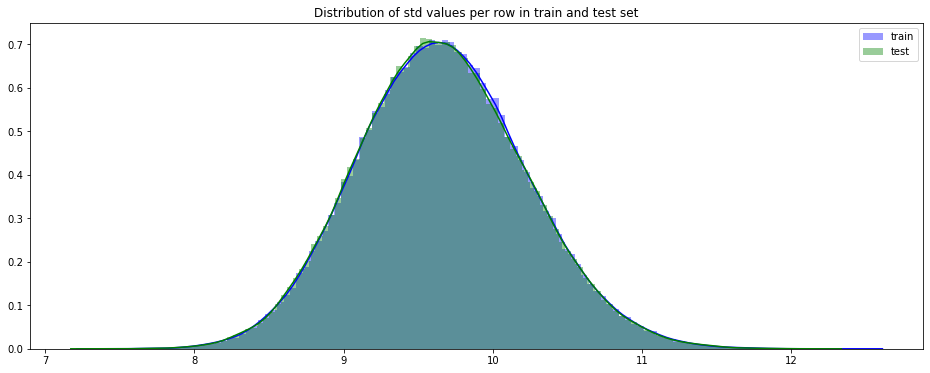

In [13]:
plt.figure(figsize = (16, 6))
plt.title('Distribution of std values per row in train and test set')
sns.distplot(train[features].std(axis = 1), color = 'blue', kde = True, bins = 120, label='train')
sns.distplot(test[features].std(axis = 1), color ='green', kde = True, bins = 120, label ='test')
plt.legend()
plt.show()

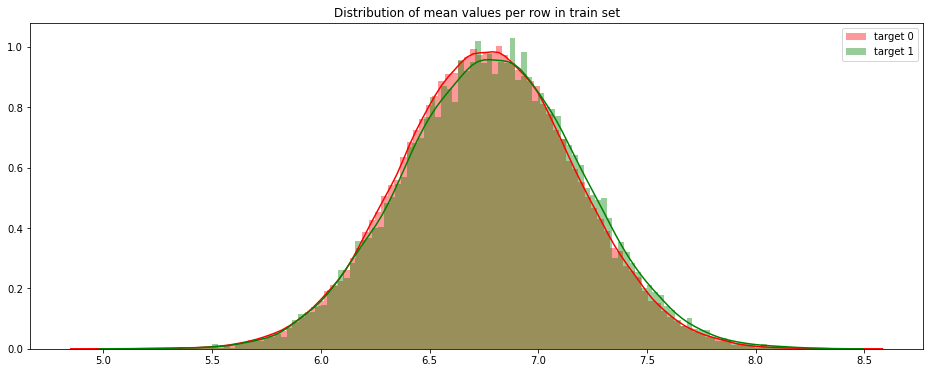

In [14]:
t0 = train.loc[y == 0]
t1 = train.loc[y == 1]
plt.figure(figsize = (16, 6))
plt.title('Distribution of mean values per row in train set')
sns.distplot(t0[features].mean(axis = 1), color = 'red', kde = True, bins = 120, label = 'target 0')
sns.distplot(t1[features].mean(axis = 1), color ='green', kde = True, bins = 120, label = 'target 1')
plt.legend()
plt.show()

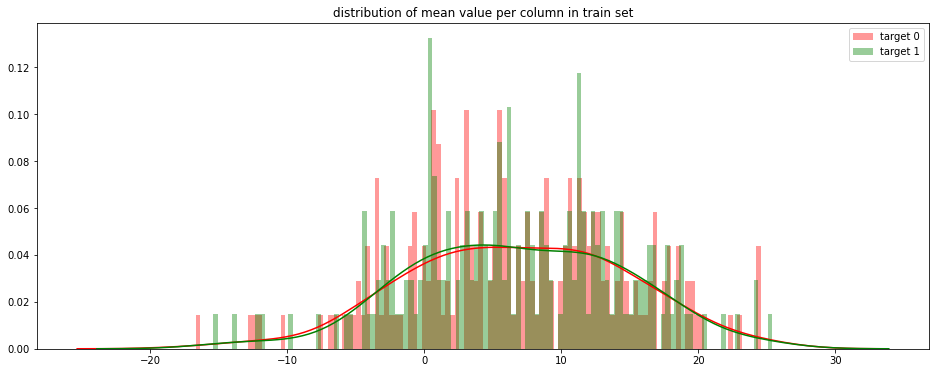

In [15]:
plt.figure(figsize =(16,6))
plt.title('distribution of mean value per column in train set')
sns.distplot(t0[features].mean(axis = 0), color = 'red', kde = True, bins = 120, label = 'target 0')
sns.distplot(t1[features].mean(axis = 0), color = 'green', kde = True, bins = 120, label = 'target 1')
plt.legend()
plt.show()

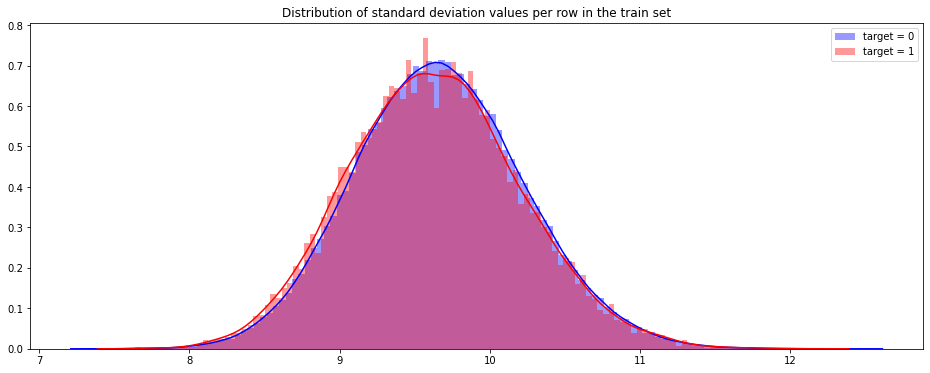

In [16]:
plt.figure(figsize=(16,6))
plt.title("Distribution of standard deviation values per row in the train set")
sns.distplot(t0[features].std(axis=1),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].std(axis=1),color="red", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

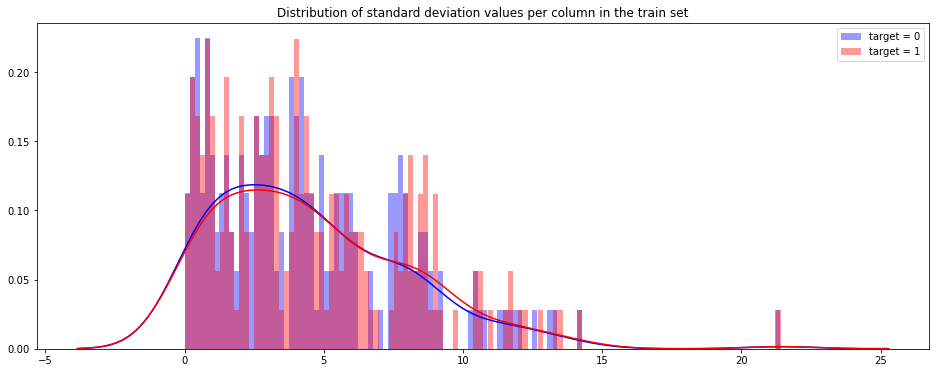

In [17]:
plt.figure(figsize=(16,6))
plt.title("Distribution of standard deviation values per column in the train set")
sns.distplot(t0[features].std(axis=0),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].std(axis=0),color="red", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

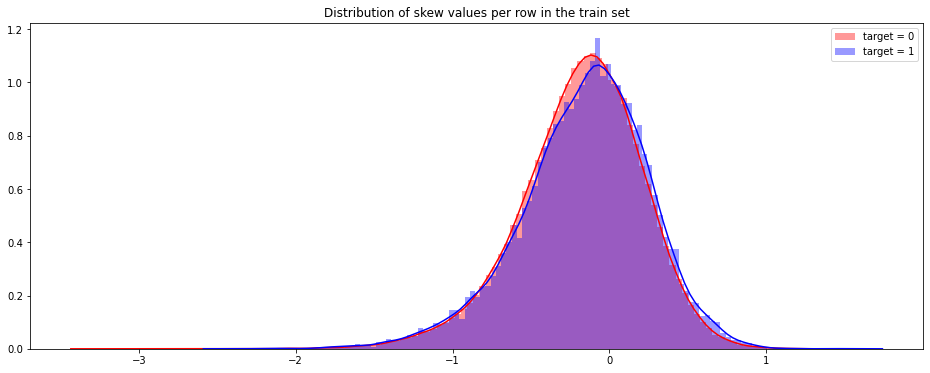

In [18]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

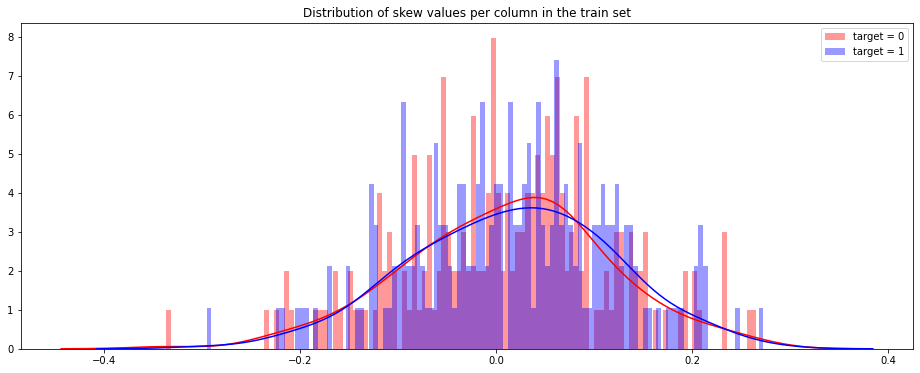

In [19]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's see now the distribution of kurtosis on rows in train separated for values of target 0 and 1. We found the distribution to be Leptokurtic

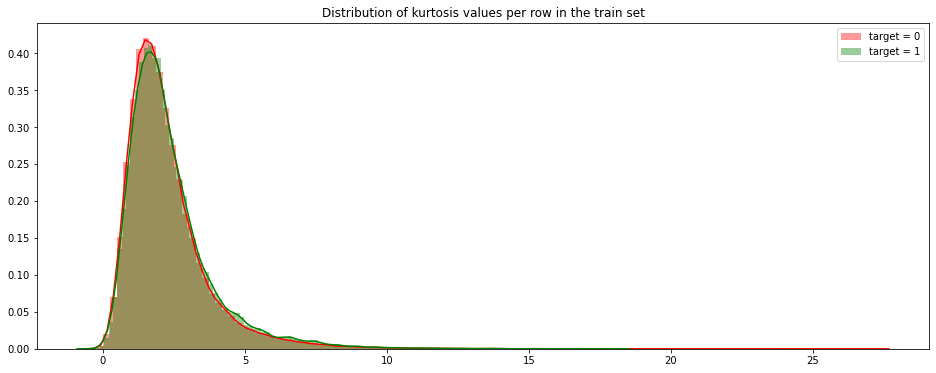

In [20]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

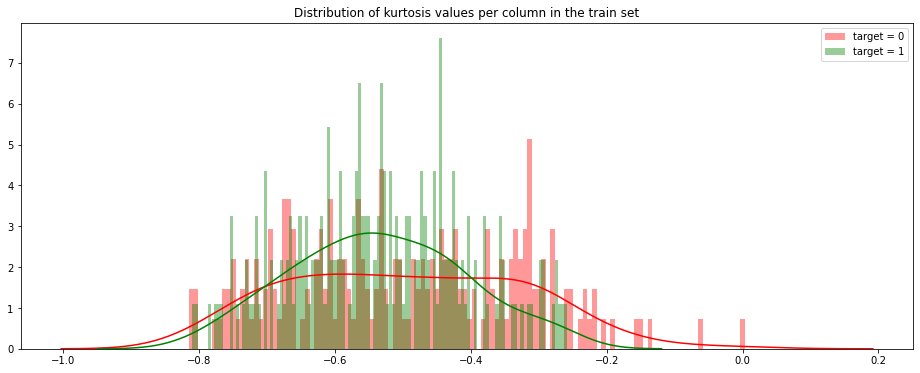

In [21]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

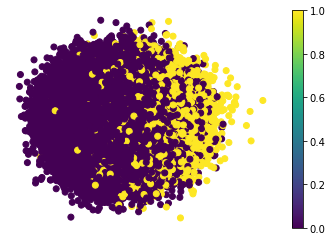

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

train = train.drop(['ID_code', 'target'], 1)

sc = StandardScaler()
train_scaled = sc.fit_transform(train)
pca_train = PCA(2).fit_transform(train_scaled)
plt.scatter(pca_train[:, 0], pca_train[:, 1], c= y)
plt.axis('off')
plt.colorbar()
plt.show()

Try kernel PCA since graph above does not represent meaningful analysis.

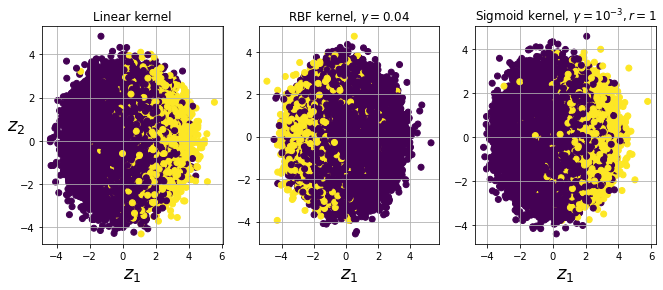

In [23]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel = 'linear', fit_inverse_transform = True)
rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.0433, fit_inverse_transform = True)
sig_pca = KernelPCA(n_components = 2, kernel = 'sigmoid', gamma = 0.001, coef0 = 1, fit_inverse_transform = True)

plt.figure(figsize = (11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"),(133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    
    pca_train = PCA(2).fit_transform(train_scaled)
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(pca_train[:, 0], pca_train[:, 1], c = y)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

Since PCA hasn't been useful, I decided to proceed with the existing dataset

In [24]:
# Data Augmentation

def augment(x, y, t= 2) :
    xs, xn = [], []
    for i in range(t) :
        mask = y >0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]) :
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:, c]
        xs.append(x1)
        
    for i in range(t//2) :
        mask = y ==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]) :
            np.random.shuffle(ids)
            x1[:, c] = x1[ids][:, c]
        xn.append(x1)
        
    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x, xs, xn])
    y = np.concatenate([y, ys, yn])
    return x, y

In [25]:
param = {'bagging_freq' : 5, 'bagging_fraction' : 0.355, 'boost_from_average' : 'false', 'boost' : 'gbdt', 'feature_fraction' : 0.041, 'learning_rate' : 0.0083,'max_depth': -1,'metric':'auc',
    'min_data_in_leaf': 80,'min_sum_hessian_in_leaf': 10.0,  'num_leaves': 13,  'num_threads': 8, 'tree_learner': 'serial', 'objective': 'binary',  'verbosity': -1 }

In [26]:
train.shape

(200000, 200)

In [27]:
num_folds = 11
features = [c for c in train.columns if c not in ['ID_code', 'target']]
folds = KFold(n_splits = num_folds, random_state = 2020)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(y))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, y.values)) :
    X_train, y_train = train.iloc[trn_idx][features], y.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], y.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print('Fold idx :', (fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label = y_tr)
    val_data = lgb.Dataset(X_valid, label = y_valid)
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval = 1000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)
    getVal[val_idx] += clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df['feature'] = features
    fold_importance_df['importance'] = clf.feature_importance()
    fold_importance_df['fold'] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))

Fold idx : 1
Training until validation scores don't improve for 4000 rounds
[1000]	training's auc: 0.892365	valid_1's auc: 0.881007
[2000]	training's auc: 0.900055	valid_1's auc: 0.887567
[3000]	training's auc: 0.905027	valid_1's auc: 0.891557
[4000]	training's auc: 0.908731	valid_1's auc: 0.894332
[5000]	training's auc: 0.911627	valid_1's auc: 0.896468
[6000]	training's auc: 0.914128	valid_1's auc: 0.898015
[7000]	training's auc: 0.916271	valid_1's auc: 0.89901
[8000]	training's auc: 0.918189	valid_1's auc: 0.899779
[9000]	training's auc: 0.919998	valid_1's auc: 0.900302
[10000]	training's auc: 0.921662	valid_1's auc: 0.900696
[11000]	training's auc: 0.923282	valid_1's auc: 0.900976
[12000]	training's auc: 0.924831	valid_1's auc: 0.901282
[13000]	training's auc: 0.926326	valid_1's auc: 0.90145
[14000]	training's auc: 0.927782	valid_1's auc: 0.901636
[15000]	training's auc: 0.929243	valid_1's auc: 0.901539
[16000]	training's auc: 0.930664	valid_1's auc: 0.90154
[17000]	training's auc: 

[7000]	training's auc: 0.916176	valid_1's auc: 0.898835
[8000]	training's auc: 0.918109	valid_1's auc: 0.89937
[9000]	training's auc: 0.919916	valid_1's auc: 0.899671
[10000]	training's auc: 0.921611	valid_1's auc: 0.899833
[11000]	training's auc: 0.923223	valid_1's auc: 0.899834
[12000]	training's auc: 0.924775	valid_1's auc: 0.899936
[13000]	training's auc: 0.926296	valid_1's auc: 0.899951
[14000]	training's auc: 0.927756	valid_1's auc: 0.899947
[15000]	training's auc: 0.929191	valid_1's auc: 0.899931
[16000]	training's auc: 0.930619	valid_1's auc: 0.899958
Early stopping, best iteration is:
[12492]	training's auc: 0.925524	valid_1's auc: 0.900004
Fold idx : 9
Training until validation scores don't improve for 4000 rounds
[1000]	training's auc: 0.892581	valid_1's auc: 0.883882
[2000]	training's auc: 0.90052	valid_1's auc: 0.891129
[3000]	training's auc: 0.905496	valid_1's auc: 0.89481
[4000]	training's auc: 0.909287	valid_1's auc: 0.897898
[5000]	training's auc: 0.912207	valid_1's au

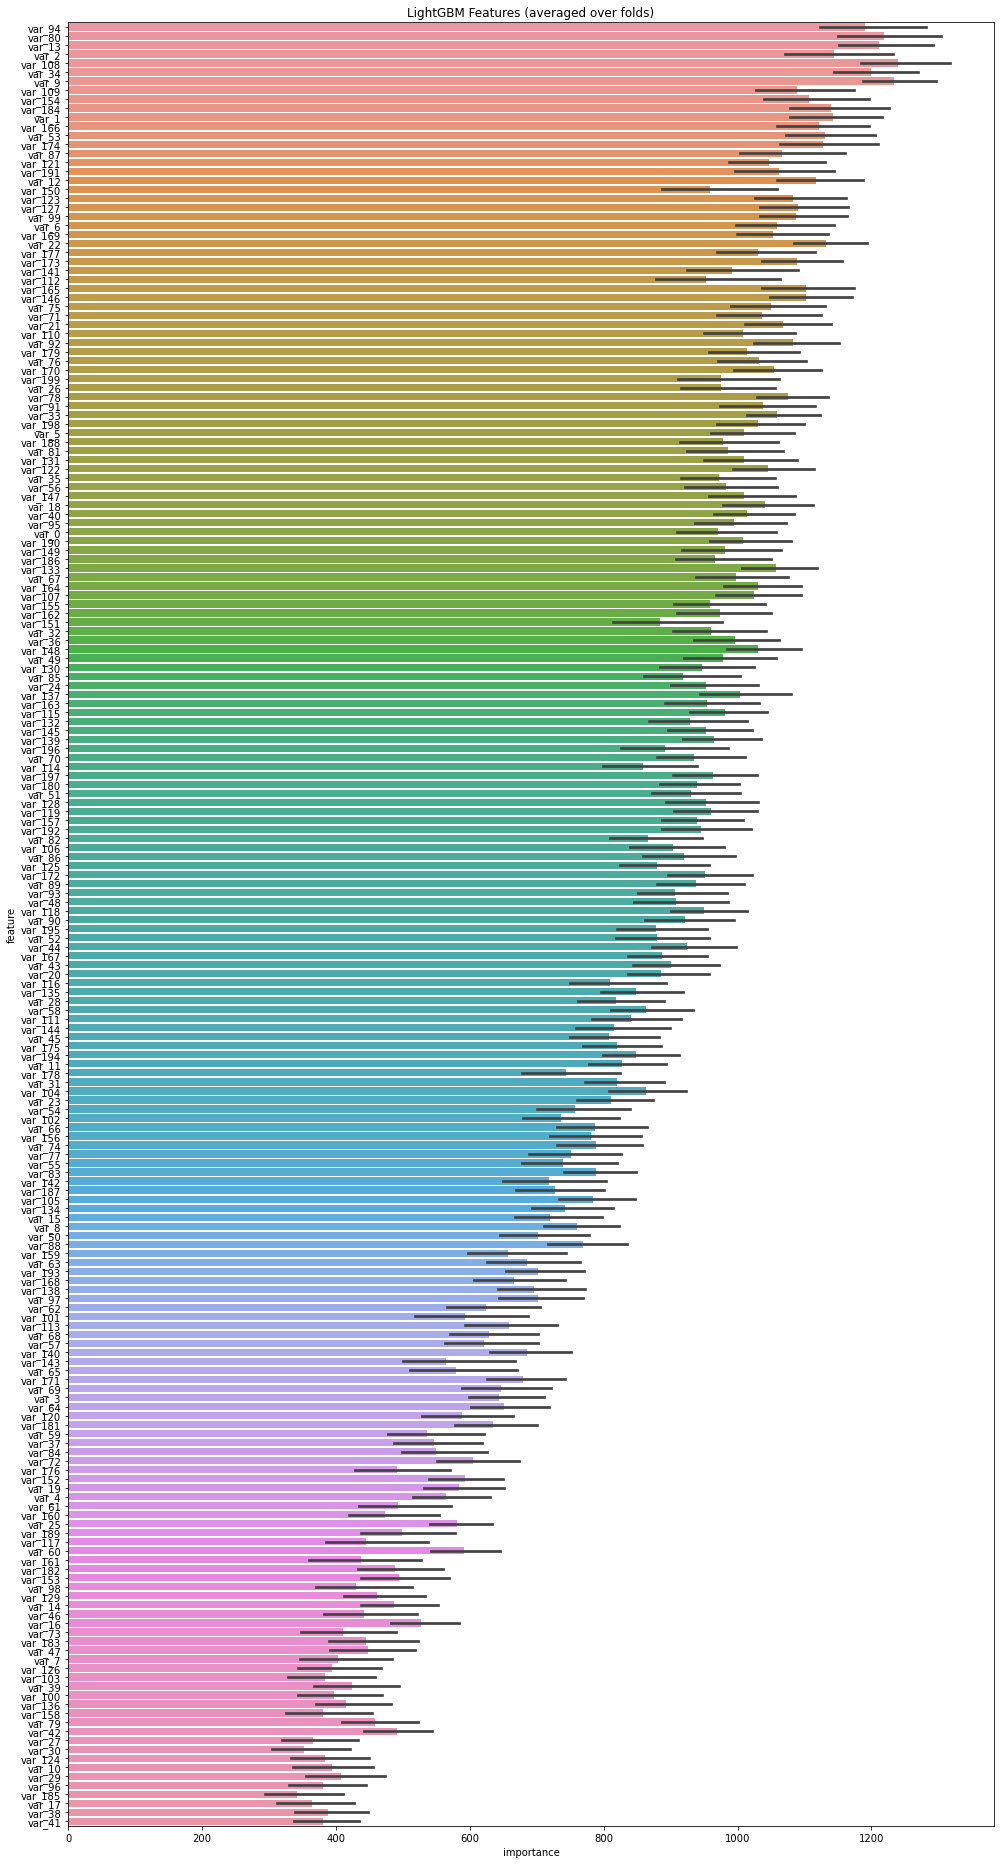

In [28]:
cols = (feature_importance_df[['feature', 'importance']].groupby('feature').mean().sort_values(by = 'importance', ascending = False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize = (14, 26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [29]:
num_sub = 26
print('Saving the Submission File')
sub = pd.DataFrame({"ID_code": test.ID_code.values})
sub["target"] = predictions
sub.to_csv('submission{}.csv'.format(num_sub), index=False)
getValue = pd.DataFrame(getVal)
getValue.to_csv("Validation_kfold.csv")

Saving the Submission File
